In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2
from sklearn.cluster import KMeans

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
im = cv2.imread('flowersm.ppm')

In [4]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
x, y, z = im.shape
im_2d = im.reshape(x*y, z)

In [6]:
im_2d.shape

(14400, 3)

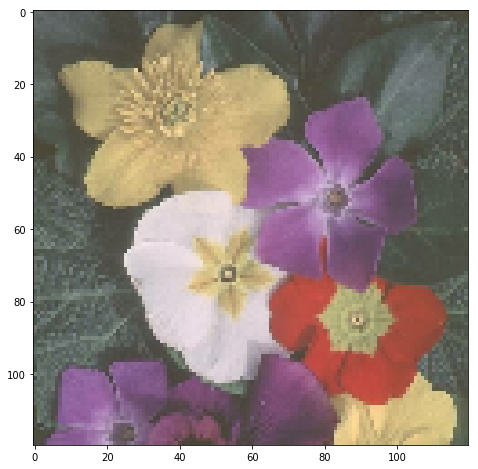

In [7]:
plt.imshow(im)

# Methods

## 1. K-Means

In [8]:
class Kmeans():
    '''Implementing Kmeans algorithm.'''
    def __init__(self, n_clusters, max_iter=100, random_state = 1111):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    
    def _distance(self, x1, x2):
        return np.linalg.norm(x1-x2, axis=1)**2
    
    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distance[:, k] = self._distance(X, centroids[k,:])
        return distance

    
    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids
    
    
    def assign_labels(self, X, centroids):
        distance = self.compute_distance(X, centroids)
        return np.argmin(distance, axis=1)
    
    
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels==k],axis=0)
        return centroids    
     
    def compute_sse(self, X, centroids, labels):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = self._distance(X[labels==k], centroids[k])
        return np.sum(np.square(distance))
    
    
    def fit(self, X):
        self.X = X
        self.centroids = self.initializ_centroids(X)
        threshold = 1
        for _ in range(self.max_iter):
            old_centroids = self.centroids
            self.labels = self.assign_labels(X, self.centroids)
            if len(np.unique(self.labels)) < self.n_clusters:
                n = len(np.unique(self.labels))
                new_label = 0
                for i in range(self.n_clusters):
                    if len(X[self.labels==i])!=0:
                        self.labels[self.labels==i] = new_label
                        new_label += 1
                self.n_clusters = n
                self.centroids = self.compute_centroids(X, self.labels)
                continue
            self.centroids = self.compute_centroids(X, self.labels)
            threshold = self._distance(old_centroids, self.centroids)[0]
            if threshold < 1e-6:
                break
        self.sse = self.compute_sse(X, self.centroids, self.labels)
        print("The number of clusters is %d for n=%d" %(len(np.unique(self.labels)), self.n_clusters))
        
    def predict(self, X):
        return self.assign_labels(X, self.centroids)


In [9]:
# performance metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

## SSE
def compute_dist(x1, x2):
    return np.linalg.norm(x1-x2, axis=1)**2

def compute_sse(X, centroids, labels):
    distance = np.zeros(X.shape[0])
    for k in range(len(np.unique(labels))):
        distance[labels == k] = compute_dist(X[labels==k], centroids[k])
    return np.sum(np.square(distance))

The number of clusters is 248 for n=248


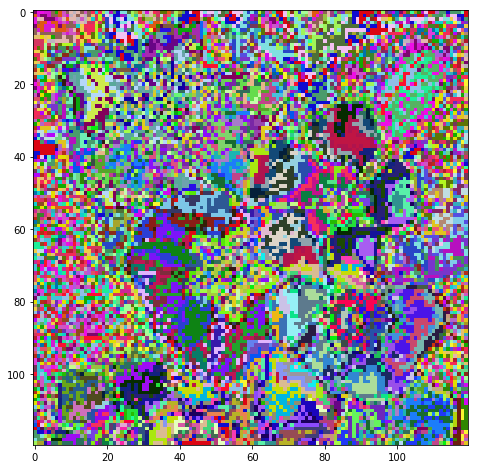

In [10]:
# using 256 color to represent the original photo
kmeans = Kmeans(n_clusters=256)
kmeans.fit(im_2d)

plt.imshow(kmeans.centroids[kmeans.labels].reshape(x, y, z))

The number of clusters is 2 for n=2
The number of clusters is 4 for n=4
The number of clusters is 8 for n=8
The number of clusters is 16 for n=16
The number of clusters is 32 for n=32
The number of clusters is 64 for n=64
The number of clusters is 126 for n=126
The number of clusters is 247 for n=247


Text(0,0.5,'Sum of Squared Error')

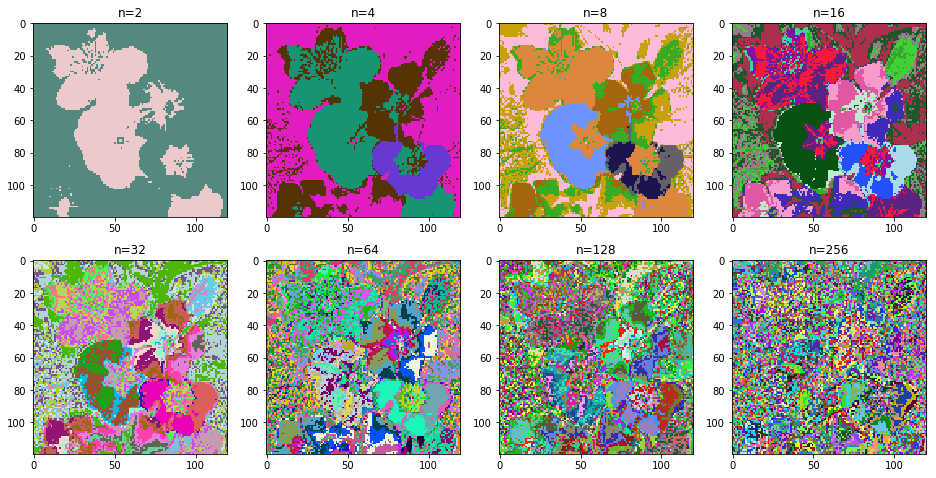

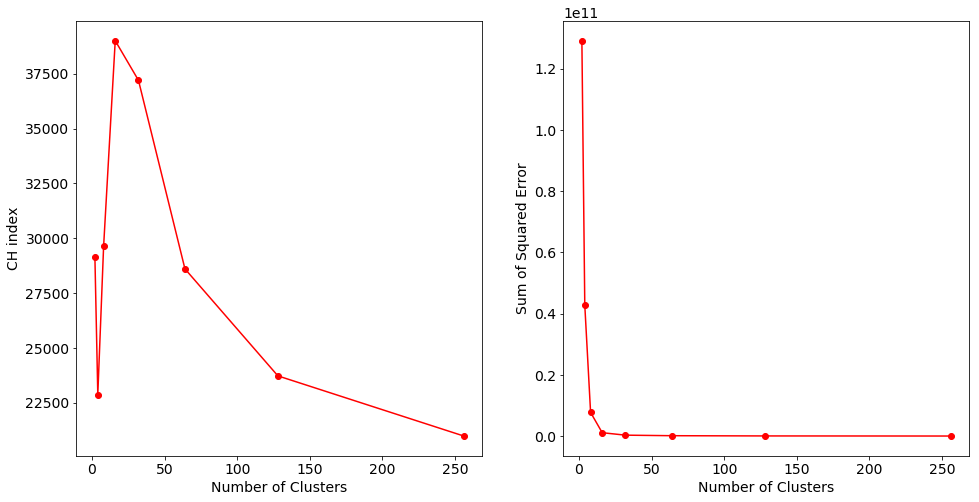

In [11]:
# check the performance for different number of clusters
n_list = [2, 4, 8, 16, 32, 64, 128, 256]

sse_list = []
ch_list = []
plt.figure(figsize=(16,8))
for i in range(len(n_list)):
    kmeans = Kmeans(n_clusters=n_list[i])
    kmeans.fit(im_2d)
    plt.subplot(2,4,i+1)
    plt.imshow(kmeans.centroids[kmeans.labels].reshape(x, y, z))
    plt.title('n=' + str(n_list[i]))
    sse = compute_sse(im_2d, kmeans.centroids, kmeans.labels)
    ch = calinski_harabaz_score(im_2d, kmeans.labels)
    sse_list.append(sse)
    ch_list.append(ch)

# plot performace metric 
plt.figure(figsize=(16,8))
plt.rc('font', size=14)
# frist plot 

plt.subplot(1, 2, 1) 
plt.plot(n_list, ch_list, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('CH index')

plt.subplot(1, 2, 2) 
plt.plot(n_list, sse_list, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')


## 2. winner-take-all algorithm

In [12]:
class WTA():
    '''Implementing WTA algorithm.'''
    def __init__(self, n_clusters,learning_rate=0.001, max_iter=100, random_state = 111):
        self.n_clusters = n_clusters
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
    
    def _distance(self, x1, x2):
        return np.linalg.norm(x1-x2, axis=1)**2
    
    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distance[:, k] = self._distance(X, centroids[k,:])
        return distance

    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids
      
    def assign_labels(self, X, centroids):
        distance = self.compute_distance(X, centroids)
        return np.argmin(distance, axis=1)
    
    def update_centroids(self, X, centroids):
        centroids =  centroids.astype(float)
        for i in range(len(X)):
            dist = self._distance(centroids, X[i])
            idx = np.argmin(dist)
            temp = centroids[idx] + (X[i]-centroids[idx])*self.learning_rate
            centroids[idx] = temp
        return centroids    
     
    def compute_sse(self, X, centroids, labels):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = self._distance(X[labels==k], centroids[k])
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        threshold = float('inf')
        for _ in range(self.max_iter):
            old_centroids = self.centroids
            self.centroids = self.update_centroids(X, old_centroids)
            threshold = self._distance(old_centroids, self.centroids)[0]
            if threshold < 1e-6:
                break
        self.labels = self.assign_labels(X, self.centroids)
        self.sse = self.compute_sse(X, self.centroids, self.labels)
        
    def predict(self, X):
        return self.assign_labels(X, self.centroids)


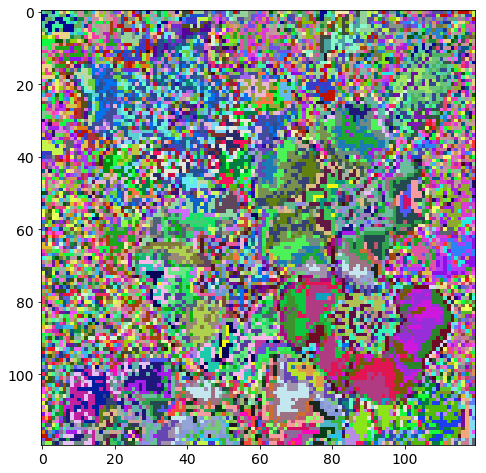

In [13]:
# using 256 color to represent the original photo
wta = WTA(n_clusters=256)
wta.fit(im_2d)

plt.imshow(wta.centroids[wta.labels].reshape(x, y, z))

Text(0,0.5,'Sum of Squared Error')

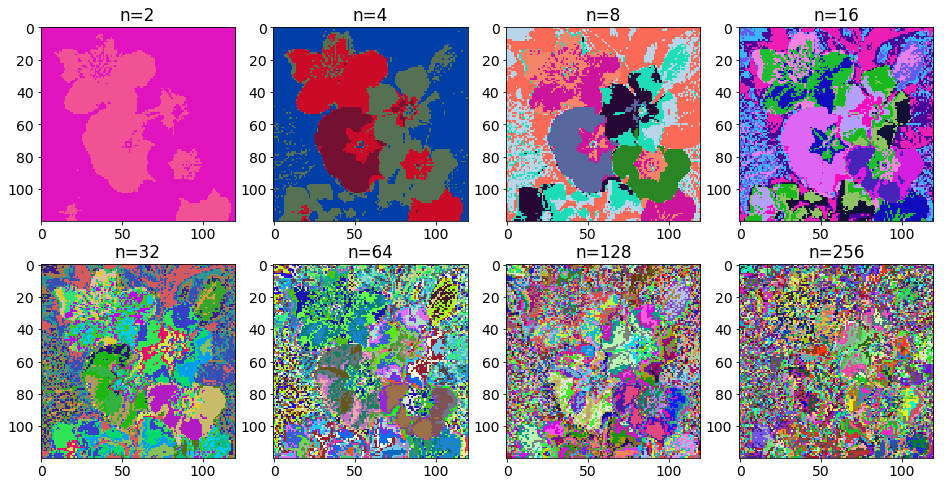

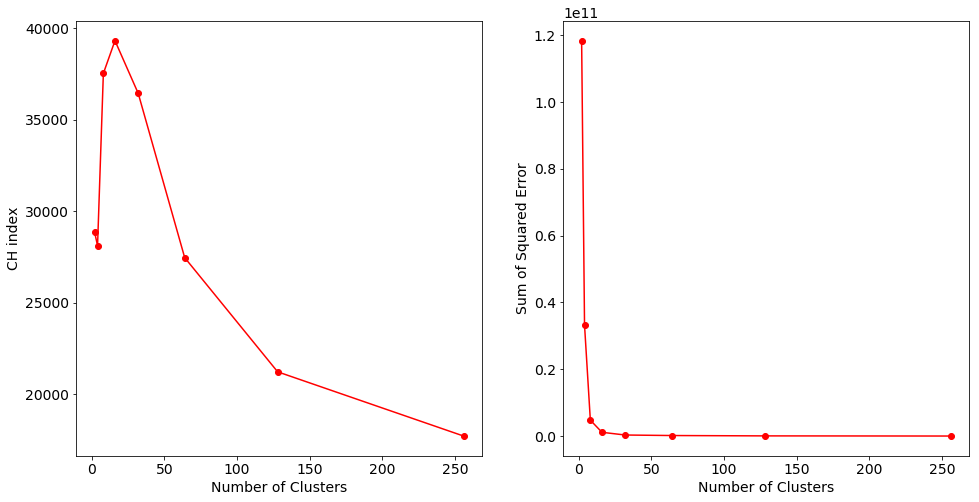

In [14]:
# check the performance for different number of clusters
n_list = [2, 4, 8, 16, 32, 64, 128, 256]

sse_list = []
ch_list = []
plt.figure(figsize=(16,8))
for i in range(len(n_list)):
    wta = WTA(n_clusters=n_list[i])
    wta.fit(im_2d)
    plt.subplot(2,4,i+1)
    plt.imshow(wta.centroids[wta.labels].reshape(x, y, z))
    plt.title('n=' + str(n_list[i]))
    sse = compute_sse(im_2d, wta.centroids, wta.labels)
    ch = calinski_harabaz_score(im_2d, wta.labels)
    sse_list.append(sse)
    ch_list.append(ch)

# plot performace metric 
plt.figure(figsize=(16,8))
plt.rc('font', size=14)
# frist plot    

plt.subplot(1, 2, 1) 
plt.plot(n_list, ch_list, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('CH index')

plt.subplot(1, 2, 2) 
plt.plot(n_list, sse_list, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')

## 3. Kohonen Feature Maps

In [15]:
class SOM:
    def __init__(self, grid, num_features, num_epochs=100, init_learning_rate=0.01, print_epoch=False):
        self.grid = np.array(grid)
        self.init_radius = min(self.grid[0],self.grid[1])
        # initialize weight vectors
        self.num_features = num_features
        self.num_epochs = num_epochs
        self.init_learning_rate = init_learning_rate
        self.print_epoch = print_epoch
        self.initialize()
    
    def initialize(self):
        self.net = np.random.random((self.grid[0],self.grid[1], self.num_features))
    
    @staticmethod
    def calculate_influence(distance, radius):
        return np.exp(-distance / (2 * (radius ** 2)))

    def find_bmu(self, x):
        bmu_idx = np.array([0, 0])  # two-deminsions
        min_dist = float('inf')
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                weight = self.net[i, j, :].reshape(1, self.num_features)
                sq_dist = np.sum((weight - x) ** 2)  # neuron and data distance
                if sq_dist < min_dist:
                    min_dist = sq_dist
                    bmu_idx = np.array([i, j])
        # get vector corresponding to bmu_idx
        bmu = self.net[bmu_idx[0], bmu_idx[1], :].reshape(1, self.num_features)
        return bmu, bmu_idx

    def decay_radius(self, iteration):
        return self.init_radius * np.exp(-iteration / self.time_constant)

    def decay_learning_rate(self, initial_learning_rate, iteration, num_iterations):
        return initial_learning_rate * np.exp(-iteration / num_iterations)

    def fit(self, X):
        """
        :param data: the data to be trained
        :param num_epochs: number of epochs (default: 100)
        :param init_learning_rate: initial learning rate (default: 0.01)
        :return:
        """
        n = X.shape[0]
        indices = np.arange(n)
        self.time_constant = self.num_epochs / np.log(self.init_radius)
        # for (epoch = 1,..., Nepochs)
        for i in range(1, self.num_epochs + 1):
            # interpolate new values for α(t) and σ (t)
            radius = self.decay_radius(i)
            learning_rate = self.decay_learning_rate(self.init_learning_rate, i, self.num_epochs)
            # visualization
            vis_interval = int(self.num_epochs/10)
            if i % vis_interval == 0 and self.print_epoch == True:
                print("SOM training epoches %d" % i)
                print("neighborhood radius ", radius)
                print("learning rate ", learning_rate)
                print("-------------------------------------")

            # shuffling data
            #np.random.shuffle(indices)
            self.label = []
            # for (record = 1,..., Nrecords)
            for record in indices:
                x = X[record, :]

                # find its Best Matching Unit
                bmu, bmu_idx = self.find_bmu(x)
                self.label.append([bmu, bmu_idx])
                # for (k = 1,..., K)
                for i in range(self.grid[0]):
                    for j in range(self.grid[1]):
                        weight = self.net[i, j, :].reshape(1, self.num_features)
                        w_dist = np.sum((np.array([i, j]) - bmu_idx) ** 2)
                        # if the distance is within the current neighbourhood radius
                        if w_dist <= radius ** 2:
                            influence = SOM.calculate_influence(w_dist, radius)
                            new_w = weight + (learning_rate * influence * (x - weight))
                            self.net[i, j, :] = new_w.reshape(1, self.num_features)

In [16]:
som = SOM([16,16],3, num_epochs=10,print_epoch=True)
som.fit(im_2d)

SOM training epoches 1
neighborhood radius  12.125732532083186
learning rate  0.009048374180359595
-------------------------------------
SOM training epoches 2
neighborhood radius  9.18958683997628
learning rate  0.008187307530779819
-------------------------------------
SOM training epoches 3
neighborhood radius  6.964404506368993
learning rate  0.007408182206817179
-------------------------------------
SOM training epoches 4
neighborhood radius  5.278031643091578
learning rate  0.006703200460356393
-------------------------------------
SOM training epoches 5
neighborhood radius  4.0
learning rate  0.006065306597126334
-------------------------------------
SOM training epoches 6
neighborhood radius  3.031433133020796
learning rate  0.005488116360940265
-------------------------------------
SOM training epoches 7
neighborhood radius  2.2973967099940706
learning rate  0.004965853037914096
-------------------------------------
SOM training epoches 8
neighborhood radius  1.741101126592248

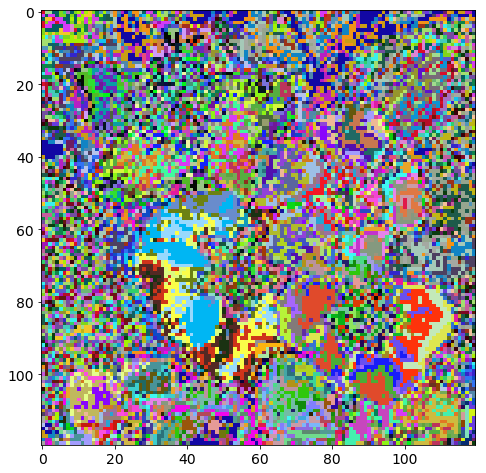

In [17]:
label = np.array(som.label)
label_change = np.array([i[0] for i in label[:, 0]])
plt.imshow(np.array(label_change.reshape(120, 120, 3)))

In [18]:
# change label format
def cen_lab(label):
    d = {} 
    centroids = []
    labels = []
    i = 0
    for n in label:
        p= tuple(n[0][0])
        if p not in d.keys():
            d[p] = i
            centroids.append(p)
            i+=1
        labels.append(d[p])
    return np.array(centroids), np.array(labels)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


Text(0,0.5,'Sum of Squared Error')

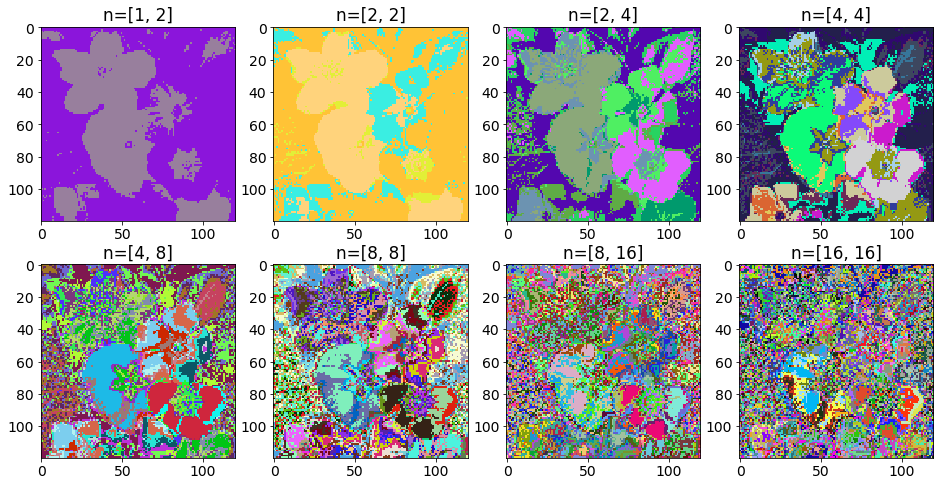

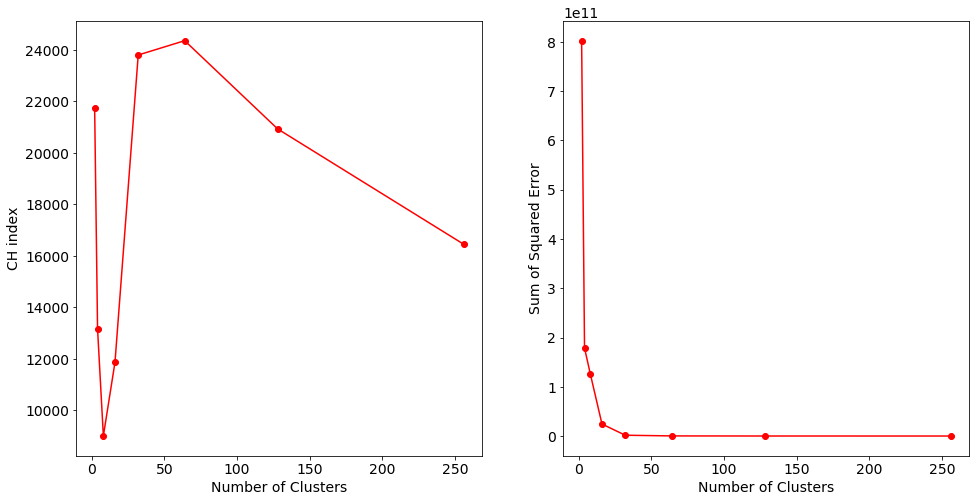

In [21]:
# check the performance for different number of clusters
n_list = [[1,2],[2,2],[2,4],[4,4], [4,8], [8,8], [8,16], [16,16]]

sse_list = []
ch_list = []
plt.figure(figsize=(16,8))
for i, grid in enumerate(n_list):
    som = SOM(grid, 3, num_epochs=10)
    som.fit(im_2d)
    centroids, labels = cen_lab(som.label)
    plt.subplot(2,4,i+1)
    label = np.array(som.label)
    label_change = np.array([k[0] for k in label[:, 0]])
    plt.imshow(np.array(label_change.reshape(x, y, z)))
    plt.title('n=' + str(n_list[i]))
    sse = compute_sse(im_2d, centroids, labels)
    ch = calinski_harabaz_score(im_2d, labels)
    sse_list.append(sse)
    ch_list.append(ch)

# plot performace metric 
plt.figure(figsize=(16,8))
plt.rc('font', size=14)
# frist plot 
 
plt.subplot(1, 2, 1) 
plt.plot([2,4,8,16,32,64,128,256], ch_list, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('CH index')

plt.subplot(1, 2, 2) 
plt.plot([2,4,8,16,32,64,128,256], sse_list, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')

## 4. Mean shift clustering

In [47]:
class MeanShift():
    def __init__(self, kernel='gaussian', kernel_bandwidth=5, n_iter = 100, epsilon=0.01, random_state = 222):
        self.kernel = kernel
        self.epsilon = epsilon
        self.kernel_bandwidth = kernel_bandwidth
        self.n_iter = n_iter
        self.random_state = random_state
    
    def _distance(self, x1, x2):
        return np.linalg.norm(x1-x2)
    
    def _kernel(self, kernel, x):
        if kernel == 'gaussian':
            cov = self.kernel_bandwidth**2 * np.eye(self.dim)
            exponent = -0.5 * np.sum(np.multiply(np.dot(x, np.linalg.inv(cov)), x), axis=1)
            weight = 1 / self.n * np.power(2*np.pi, self.dim/2) * np.power(np.linalg.det(cov), 0.5) * np.exp(exponent)
        else:
            weight = 1 * np.linalg.norm(x, axis=1)<=5
        return weight
    
    def shift(self, x, points):
        point_weights = self._kernel(self.kernel, x-points)
        tiled_weights = np.tile(point_weights, [len(x), 1])
        # denominator
        denominator = sum(point_weights)
        shifted_point = np.multiply(tiled_weights.transpose(), points).sum(axis=0) / denominator
        return shifted_point
            
    def fit(self, X):
        shift = [True] * X.shape[0]
        self.shift_points = np.array(X).astype(float)
        min_dist = 1
        self.n, self.dim = X.shape[0], X.shape[1]
        it = 0
        while min_dist > self.epsilon and it < self.n_iter:
            it+=1
            if it%20==0:
                print("Iteration %d" %it)
            min_dist = 0
            for i in range(0, len(self.shift_points)):
                if not shift[i]:
                    continue
                p_new = self.shift_points[i]
                p_new_start = p_new
                p_new = self.shift(p_new, X)
                dist = self._distance(np.array(p_new), p_new_start)
                if dist > min_dist:
                    min_dist = dist
                if dist < self.epsilon:
                    shift[i] = False
                self.shift_points[i] = p_new

In [48]:
meanshift = MeanShift()
meanshift.fit(im_2d)

Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100


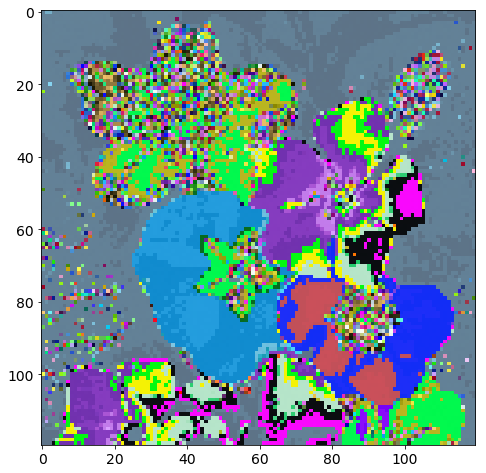

In [49]:
plt.imshow(meanshift.shift_points.reshape(x, y, z))

In [50]:
# number of clusters
len(np.unique(meanshift.shift_points, axis=0))

8458

In [51]:
np.unique(meanshift.shift_points, axis=0)

array([[ 77.6672321 ,  79.76083894,  70.80579445],
       [ 77.66723753,  79.76085192,  70.80580845],
       [ 77.66724705,  79.76087473,  70.80583304],
       ...,
       [242.48913184, 209.8697251 , 146.5496058 ],
       [242.48952801, 209.8699182 , 146.54964303],
       [242.48998639, 209.87014166, 146.54968616]])